In [1]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torchvision
from PIL import Image
from lxml import etree
import glob
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1.8.1+cu101
True


device(type='cuda', index=0)

## 测试一张图片

In [2]:
batch_size = 8
pil_img_ = Image.open("../all_datasets/object_dataset/images/Abyssinian_1.jpg")
np_img = np.array(pil_img_)
np_img.shape

(400, 600, 3)

In [3]:
xml = open("../all_datasets/object_dataset/annotations/xmls/Abyssinian_1.xml").read()
sel = etree.HTML(xml)
xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
xmin, xmax

(333, 425)

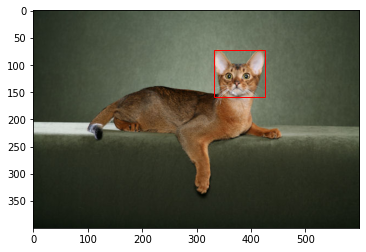

In [4]:
plt.imshow(np_img)
rect = Rectangle(xy=(xmin, ymin), width=(xmax-xmin), height=(ymax-ymin), fill=False, color='red')
ax = plt.gca()
ax.axes.add_patch(rect)

In [4]:
pil_img = pil_img_.resize((224, 224))

width = int(xmax-xmin)
height = int(ymax-ymin)

xmin = (xmin / width) * 224
ymin = (ymin / height) * 224
xmax = (xmax / width) * 224
ymax = (ymax / height) * 224

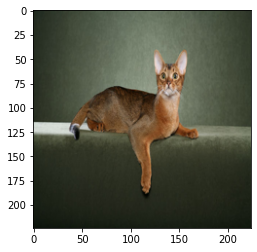

In [5]:
plt.imshow(pil_img)
rect2 = Rectangle(xy=(xmin, ymin), width=(xmax-xmin), height=(ymax-ymin), fill=False, color='black')
ax2 = plt.gca()
ax2.axes.add_patch(rect2)

## 读取数据